Student Details

Name: Vipul Popat

ID: 18195121

# Lab 5: Feature Selection 

This notebook builds on top of Lab 4 by introducing feature selection into the process of selecting the best classifier for a binary classification problem.

The feature selection method applied here is Recursive Feature Elimination (RFE) as demonstrated in the tutorial at https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/.

In this demonstration we use a modified version of the seeds data set (see https://archive.ics.uci.edu/ml/datasets/seeds), which is the same data set used in Lab 4.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')


### Load and prepare the dataset for training and evaluation
Feel free to apply any other pre-processing technique at this point.

In [2]:
df = pd.read_csv("./winequality_red.csv")
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [3]:
# target attribute
target_attribute_name = 'quality'
target = df[target_attribute_name]

# predictor attributes
predictors = df.drop(target_attribute_name, axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

Split the data set into a training (80%) and test (20%) data sets.

In [4]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target)

## B. Feature Selection

#### 1. Apply RFE with SVM for selecting the best features

In [5]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorSVM.support_)
print(selectorSVM.ranking_)

[False  True False False False False False False False  True  True]
[5 1 9 4 2 7 3 6 8 1 1]


#### 2. Apply RFE with Logistic Regression for selecting the best features

In [6]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression()
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorLR.support_)
print(selectorLR.ranking_)

[False  True False False False False  True False False False  True]
[7 1 6 9 5 8 1 3 4 2 1]


## B. Evaluate on the Test Data Set

Apply the selectors to prepare training data sets only with the selected features

__Note:__ The same selectors are applied to the test data set. However, it is important that the test data set was not used by (it's invisible to) the selectors. 

In [7]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [8]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [9]:
classifier = svm.SVC()

In [10]:
model1 = classifier.fit(predictors_train_SVMselected, target_train)
model1.score(predictors_test_SVMselected, target_test)

0.540625

In [11]:
model2 = classifier.fit(predictors_train_LRselected, target_train)
model2.score(predictors_test_LRselected, target_test)

0.5625

In [12]:
model3 = classifier.fit(predictors_train, target_train)
model3.score(predictors_test, target_test)

0.546875

## C. Conclusion

The results above, give evidence that model2 and model3 performance scores are equal.
We should also validate the above conclusion by running the experiment multiple times with different training/test stratified split datasets.


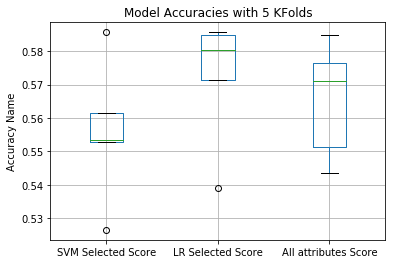

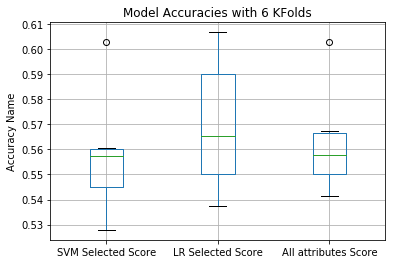

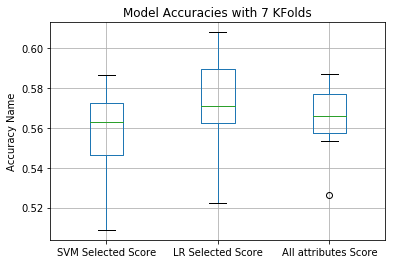

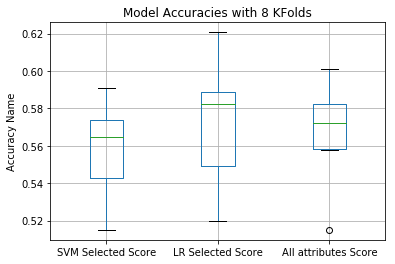

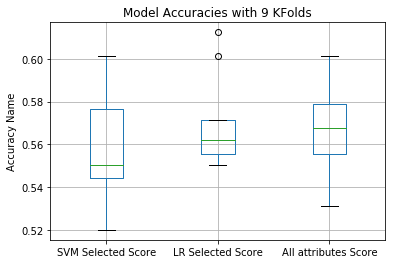

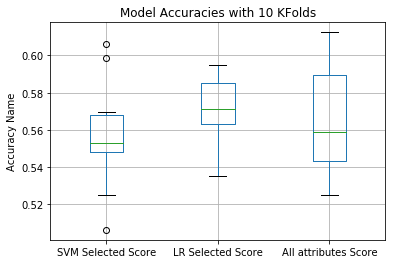

In [14]:
for i in range(5,11):

    model1_scores = []
    model2_scores = []
    model3_scores = []
    
    kfold = StratifiedKFold(n_splits=i, shuffle=True)
    kfold.get_n_splits(predictors, target)
    
    for train_index, test_index in kfold.split(predictors, target):
        predictors_train, predictors_test = predictors[train_index], predictors[test_index]
        target_train, target_test = target[train_index], target[test_index]
        
        predictors_train_SVMselected = selectorSVM.transform(predictors_train)
        predictors_test_SVMselected = selectorSVM.transform(predictors_test)
        predictors_train_LRselected = selectorLR.transform(predictors_train)
        predictors_test_LRselected = selectorLR.transform(predictors_test)
        
        classifier = svm.SVC()
        model1 = classifier.fit(predictors_train_SVMselected, target_train)
        model1_scores.append(model1.score(predictors_test_SVMselected, target_test))
        
        model2 = classifier.fit(predictors_train_LRselected, target_train)
        model2_scores.append(model2.score(predictors_test_LRselected, target_test))
        
        model3 = classifier.fit(predictors_train, target_train)
        model3_scores.append(model3.score(predictors_test, target_test))
    
    df = pd.DataFrame({
        'SVM Selected Score': model1_scores,
        'LR Selected Score' : model2_scores,
        'All attributes Score' : model3_scores
    })
    
    df.boxplot()
    plt.title("Model Accuracies with {} KFolds".format(i))
    plt.ylabel("Accuracy")
    plt.show()

### Conclusion

When the number of KFolds increase, the number of outliers increase in the accuracy performance The mean score seems to stay the same across the various kfolds.

Linear Model seems to perform the best having the highest mean/average score as well as relatively lower/smaller variance in scores.